In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io
from datetime import datetime
%matplotlib inline

In [91]:
motes = ["0024","003a","0047","003f","0046","004a","0024","0048","0055","0037","004f","0040","002f"]
motedict = {}
for m in motes:
    df = pd.read_csv("soda_data/{0}.csv".format(m),names=[0,m])
    df = df.set_index(pd.to_datetime(df.pop(0), unit='ns'))
    df = df.resample('5min').max()
    motedict[m] = df
for m, df in motedict.items():
    print df.count()

0048    1664
dtype: int64
0024    831
dtype: int64
0040    1663
dtype: int64
0037    1663
dtype: int64
0046    1663
dtype: int64
0047    1664
dtype: int64
002f    1663
dtype: int64
0055    1661
dtype: int64
004a    1664
dtype: int64
003f    1626
dtype: int64
003a    1664
dtype: int64
004f    1663
dtype: int64


1664


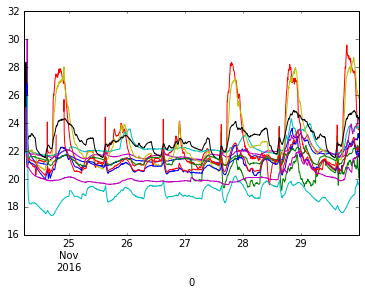

In [92]:
# merge
dfs = motedict.values()
current = dfs[0]
for df in dfs[1:]:
    current = current.merge(df, how='outer',left_index=True, right_index=True)
print len(current)
current.plot(legend=False)

11


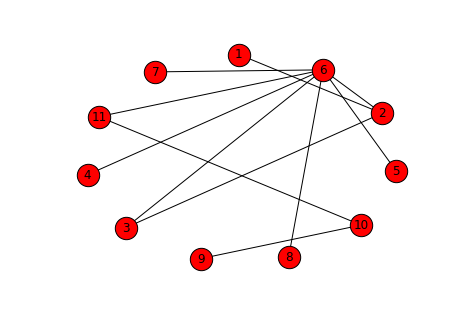

In [93]:
# need the soda printout map!  Then we assign nodes, etc
mote_mapping = {
    '0047': 1,
    '002f': 2,
    '0037': 3,
    '004f': 4,
    '0048': 5,
    '004a': 7,
    '0046': 8,
    '003a': 9,
    '0024': 10,
    '0055': 11
}
edges = [
    (1,2),
    (2,6),
    (2,3),
    (3,6),
    (4,6),
    (5,6),
    (6,7),
    (6,8),
    (9,10),
    (10,11),
    (11,6)
]
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, iterations=500, k=2.0, scale=10.0)
nx.draw(G,pos,node_size=500,with_labels=True)
nodes = G.nodes()
minNode = min(nodes)
edges = G.edges()
edges = [(nodes.index(x)+1,nodes.index(y)+1) for (x,y) in edges]
e = np.array(edges, dtype=object)
print len(e)
scipy.io.savemat('soda_amplab_edges.mat',{'edges': e})

In [94]:
# want to rename the data columns in terms of which node in the graph they are
# also need data for all of the nodes: "easiest" way is to take average of temperatures of nearby nodes
# This is what gets put in 'sdh_idea1.csv'

# First take our empirical data and replace the keti ids with the node ids
current = current[mote_mapping.keys()].rename(columns=mote_mapping)
# Now we need to "fill" the graph: For each node for which we have original data (make this list at the beginning),
# we do a breadth-first traversal through the tree. At each node we visit, its temperature becomes the average of
# its neighboring nodes; if the node's neighbors do not have any values, then we just use the value we are
# propagating from; if the node already has a value (that's not an empirical value), then its new value is the
# average of its new temperature and its neighbors (using the propagating value if neighbors have no values)
empirical_nodes = current.columns
print empirical_nodes
data_row = current.iloc[0]
result = pd.DataFrame()
rownum = 0
t = datetime.now()
for row in current.iterrows():
    rownum += 1
    for en in empirical_nodes:
        data_row = row[1]
        if pd.isnull(data_row[en]):
            #print en,'has no data'
            continue
        propagate_point = data_row[en]
        bfs_edges = nx.algorithms.traversal.bfs_edges(G, en)
        # the 2nd item (index 1) of each edge is the next node
        bfs_nodes = [x[1] for x in bfs_edges if x[1] not in empirical_nodes or pd.isnull(data_row[x[1]])]
        for node in bfs_nodes:
            neighbors = G.neighbors(node)
            # get data from neighbors
            datas = [data_row.get(n, propagate_point) for n in neighbors]
            # get data from ourself
            datas.append(data_row.get(node, propagate_point))
            # filter out nans
            datas = filter(lambda x: not pd.isnull(x), datas)
            data_row[node] = np.mean(datas)
    if rownum % 1000 == 0:
        print rownum, len(current), (datetime.now()-t).total_seconds()
        t = datetime.now()
    result = result.append(data_row)

Int64Index([5, 2, 8, 10, 11, 7, 3, 9, 4, 1], dtype='int64')
1000 1664 6.768883


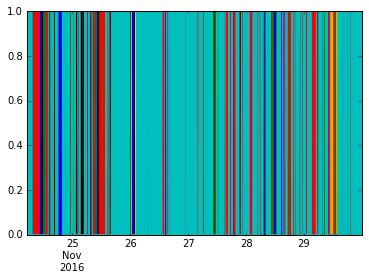

In [95]:
# compute whether or not temperature going up or not
df = result.copy()
diffs = df.interpolate(method='time').diff(axis=0)
diffs[diffs > 0] = 1
diffs[diffs < 0] = 0
diffs = diffs.fillna(0)
diffs.plot(legend=False)
diffs.tail()
diffs.to_csv("soda_amplab_data.csv",sep="\t",header=False,index=False)

In [62]:
# TODO: need a method that takes the log likelihood and theta from the
# output and then associates them with the edges
# TODO: compare different methods and look at their log-likelihoods (which one maximizes?!)
# TODO: make the list of figures you will have

In [63]:
def dump(edges, theta):
    res = ""
    for i, e in enumerate(edges):
        res += '\nEdge {0} => {1}'.format(e, str(theta[i]).replace('\n','\n\t\t'))
    print res

Soda hall figures:

- 1, 5, 10, 30 min resolution
- min/max/mean bucket
- 'structured' vs fully connected

In [27]:
# RESULTS
# loglikelihood =  -4840.9
theta = np.loadtxt('soda_amplab_10min_mean_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)
# TODO: networkx code to visualizeeeeee


Edge (1, 2) => [[ 0.72375073 -1.46183227]
		 [-0.97405356  0.2841197 ]]
Edge (2, 3) => [[ 0.07491707  0.2617407 ]
		 [ 0.03524091 -0.13075652]]
Edge (2, 6) => [[ 0.51700809 -1.09190424]
		 [-1.12688203  0.51073015]]
Edge (3, 6) => [[ 0.28754364 -0.66501183]
		 [-0.65845259  0.39498608]]
Edge (4, 6) => [[ 0.29419675 -0.41862319]
		 [-0.23121897  0.18766916]]
Edge (5, 6) => [[ 0.36621535 -0.58387277]
		 [-0.27967135  0.21830613]]
Edge (6, 7) => [[ 0.47759998 -0.88462582]
		 [-0.94726666  0.46192822]]
Edge (6, 8) => [[ 0.44462996 -0.57447089]
		 [-0.82078251  0.36255574]]
Edge (6, 11) => [[ 0.491023   -1.0387765 ]
		 [-1.00508623  0.49841651]]
Edge (9, 10) => [[ 0.58404034 -1.11803037]
		 [-0.91869747  0.3925617 ]]
Edge (10, 11) => [[ 0.50416738 -1.34493595]
		 [-1.34493595  0.60650025]]


In [21]:
# loglikelihood = -10319
theta = np.loadtxt('soda_amplab_5min_mean_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.64499465 -0.96317663]
		 [-0.76928214  0.22244116]]
Edge (2, 3) => [[ 0.06116882  0.17812503]
		 [ 0.01289872 -0.07523286]]
Edge (2, 6) => [[ 0.46760345 -0.9221658 ]
		 [-0.905692    0.47198913]]
Edge (3, 6) => [[ 0.27979329 -0.57273985]
		 [-0.5851691   0.35568709]]
Edge (4, 6) => [[ 0.26407221 -0.3598546 ]
		 [-0.2056277   0.17047152]]
Edge (5, 6) => [[ 0.31562144 -0.46380069]
		 [-0.27553969  0.21578671]]
Edge (6, 7) => [[ 0.42744401 -0.75246376]
		 [-0.76214005  0.42448037]]
Edge (6, 8) => [[ 0.40101076 -0.46062368]
		 [-0.67990195  0.31416086]]
Edge (6, 11) => [[ 0.49062292 -0.90846801]
		 [-1.00330211  0.46803835]]
Edge (9, 10) => [[ 0.52467163 -0.93081883]
		 [-0.78893825  0.37948962]]
Edge (10, 11) => [[ 0.46984403 -1.05676002]
		 [-1.16464048  0.55869463]]


In [37]:
# loglikelihood = -1494.0
# 30m
theta = np.loadtxt('soda_amplab_30min_mean_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.74165083 -1.40186957]
		 [-1.35959692  0.3349988 ]]
Edge (2, 3) => [[ 0.06917666  0.47211045]
		 [ 0.17798131 -0.18525928]]
Edge (2, 6) => [[ 0.56217623 -1.30085092]
		 [-1.37888666  0.55466433]]
Edge (3, 6) => [[ 0.34567526 -1.05534956]
		 [-1.07985657  0.50221215]]
Edge (4, 6) => [[ 0.45886588 -0.87294029]
		 [-0.31015493  0.23638878]]
Edge (5, 6) => [[ 0.43457319 -0.78592891]
		 [-0.5389965   0.34830669]]
Edge (6, 7) => [[ 0.49036455 -1.60943791]
		 [-1.00215202  0.58778666]]
Edge (6, 8) => [[ 0.48258241 -0.76214005]
		 [-0.96825047  0.42744401]]
Edge (6, 11) => [[ 0.51335407 -1.32175584]
		 [-1.11135131  0.55004634]]
Edge (9, 10) => [[ 0.5708576  -1.24559448]
		 [-0.94548989  0.44080447]]
Edge (10, 11) => [[ 0.49587795 -1.13937172]
		 [-1.31238621  0.57331076]]


In [44]:
# loglikelihood = -118180
# 30s
theta = np.loadtxt('soda_amplab_30sec_mean_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.32131051 -0.20580231]
		 [-0.02624839 -0.18274634]]
Edge (2, 3) => [[ 0.11450359  0.26126428]
		 [-0.11141478 -0.32427212]]
Edge (2, 6) => [[ 0.32382474 -0.55728424]
		 [-0.48095187  0.35625269]]
Edge (3, 6) => [[ 0.19051006 -0.37305592]
		 [-0.24520769  0.27835471]]
Edge (4, 6) => [[ 0.34820918 -0.53875973]
		 [ 0.02709214 -0.02784661]]
Edge (5, 6) => [[ 0.37574369 -0.60894185]
		 [ 0.01490124 -0.01512665]]
Edge (6, 7) => [[ 0.36692299 -0.01686298]
		 [-0.58570501  0.01658333]]
Edge (6, 8) => [[ 0.36839852  0.05635795]
		 [-0.58954051 -0.05972487]]
Edge (6, 11) => [[ 0.38384221 -0.17262866]
		 [-0.63094978  0.14716921]]
Edge (9, 10) => [[ 0.44295684 -0.44225354]
		 [-0.27773511  0.04172789]]
Edge (10, 11) => [[ 0.20729027 -0.33058329]
		 [-0.3823236   0.3280721 ]]


In [50]:
# loglikelihood = -1504.0
# 30min min
theta = np.loadtxt('soda_amplab_30min_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.80604885 -1.52285355]
		 [-1.07929121  0.18530622]]
Edge (2, 3) => [[ 0.3111281   0.31919794]
		 [-0.26209538 -0.24471717]]
Edge (2, 6) => [[ 0.49440187 -1.20461419]
		 [-1.01849378  0.5315661 ]]
Edge (3, 6) => [[ 0.22122511 -1.05234813]
		 [-0.49702719  0.42785025]]
Edge (4, 6) => [[ 0.5389965  -1.25276297]
		 [-0.03278982  0.0317487 ]]
Edge (5, 6) => [[ 0.5313919  -1.20831121]
		 [-0.21511138  0.17693071]]
Edge (6, 7) => [[ 0.54654371 -0.63062682]
		 [-1.29928298  0.38372512]]
Edge (6, 8) => [[ 0.51600698 -0.34294475]
		 [-1.1249296   0.25489225]]
Edge (6, 11) => [[ 0.56146936 -0.99164017]
		 [-1.39936644  0.48798613]]
Edge (9, 10) => [[ 0.63387057 -1.19680431]
		 [-0.71496623  0.28046182]]
Edge (10, 11) => [[ 0.46112649 -1.22673339]
		 [-1.47570095  0.65780781]]


In [56]:
# loglikelihood = -4658.3
# 10min min
theta = np.loadtxt('soda_amplab_10min_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.80532822 -1.25053238]
		 [-1.00935301  0.10642708]]
Edge (2, 3) => [[ 0.29303188  0.33401318]
		 [-0.30950616 -0.326186  ]]
Edge (2, 6) => [[ 0.44512126 -1.10093296]
		 [-0.82188605  0.51158077]]
Edge (3, 6) => [[ 0.20813527 -0.82421979]
		 [-0.39850015  0.41456692]]
Edge (4, 6) => [[ 0.49491017 -1.02262638]
		 [ 0.19290367 -0.23922969]]
Edge (5, 6) => [[ 0.55710638 -1.36890262]
		 [-0.01069529  0.01058211]]
Edge (6, 7) => [[ 0.5646158  -0.35364004]
		 [-1.42201244  0.26072626]]
Edge (6, 8) => [[ 0.55206858 -0.06595797]
		 [-1.33500107  0.0618754 ]]
Edge (6, 11) => [[ 0.55710638 -0.63127178]
		 [-1.36890262  0.3839589 ]]
Edge (9, 10) => [[ 0.67372909 -1.31218639]
		 [-0.72241756  0.24971058]]
Edge (10, 11) => [[ 0.41598065 -1.05104515]
		 [-1.46599299  0.67793178]]


In [64]:
# ll = -9423.7 
# 5min min
theta = np.loadtxt('soda_amplab_5min_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.789208   -0.987284  ]
		 [-0.79500194 -0.02586885]]
Edge (2, 3) => [[ 0.34534004  0.40175774]
		 [-0.45796615 -0.53471436]]
Edge (2, 6) => [[ 0.409408   -1.06289792]
		 [-0.70467552  0.50364087]]
Edge (3, 6) => [[ 0.17033834 -0.74737574]
		 [-0.27629852  0.41068447]]
Edge (4, 6) => [[ 0.5176833  -1.13362433]
		 [ 0.22340564 -0.28811904]]
Edge (5, 6) => [[ 0.58172567 -1.55648119]
		 [ 0.18275833 -0.22379907]]
Edge (6, 7) => [[ 0.58420398 -0.09478607]
		 [-1.57775858  0.08657441]]
Edge (6, 8) => [[ 0.57550287  0.1957737 ]
		 [-1.50518789 -0.24366728]]
Edge (6, 11) => [[ 0.55659872 -0.39503477]
		 [-1.36542595  0.28242582]]
Edge (9, 10) => [[ 0.72508366 -1.36724617]
		 [-0.63252256  0.13892547]]
Edge (10, 11) => [[ 0.35192745 -0.87304142]
		 [-1.23251921  0.68210456]]


In [70]:
# ll =   -48513
# 1min min
theta = np.loadtxt('soda_amplab_1min_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.72865161 -0.50104004]
		 [-0.24459397 -0.61839655]]
Edge (2, 3) => [[ 0.39000471  0.49299444]
		 [-0.62160099 -0.90639532]]
Edge (2, 6) => [[ 0.32006399 -0.70651988]
		 [-0.47284755  0.41045646]]
Edge (3, 6) => [[ 0.13558344 -0.64066668]
		 [-0.19122171  0.43360236]]
Edge (4, 6) => [[ 0.56060052 -1.3932148 ]
		 [ 0.34816828 -0.53866042]]
Edge (5, 6) => [[ 0.59382451 -1.6654846 ]
		 [ 0.33479015 -0.50691172]]
Edge (6, 7) => [[ 0.55958401  0.31666961]
		 [-1.38607192 -0.46608973]]
Edge (6, 8) => [[ 0.57497475  0.38192216]
		 [-1.50096767 -0.6256718 ]]
Edge (6, 11) => [[ 0.55576283  0.12631588]
		 [-1.3597315  -0.14461028]]
Edge (9, 10) => [[ 0.80385396 -0.92716697]
		 [-0.33225039 -0.42635486]]
Edge (10, 11) => [[ 0.14497273 -0.35585523]
		 [-0.55430273  0.59702928]]


In [82]:
# -97156
# 30sec min
theta = np.loadtxt('soda_amplab_30sec_min_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.74818488 -0.40261926]
		 [-0.18308746 -0.95301094]]
Edge (2, 3) => [[ 0.40892245  0.50217097]
		 [-0.69071109 -0.98245261]]
Edge (2, 6) => [[ 0.28214818 -0.60453919]
		 [-0.39410456  0.37463778]]
Edge (3, 6) => [[ 0.11379687 -0.5301338 ]
		 [-0.15577604  0.39931187]]
Edge (4, 6) => [[ 0.55903059 -1.38220754]
		 [ 0.34975998 -0.54253473]]
Edge (5, 6) => [[ 0.5984898  -1.71129967]
		 [ 0.30599056 -0.44311945]]
Edge (6, 7) => [[ 0.56029545  0.33368787]
		 [-1.39106499 -0.50435877]]
Edge (6, 8) => [[ 0.56458406  0.38007086]
		 [-1.42178105 -0.62061857]]
Edge (6, 11) => [[ 0.54089472  0.19291751]
		 [-1.26422856 -0.23925102]]
Edge (9, 10) => [[ 0.81695539 -0.87560097]
		 [-0.32019814 -0.52123683]]
Edge (10, 11) => [[ 0.12050169 -0.30119627]
		 [-0.46374912  0.56165962]]


In [89]:
# MAX
# ll = -1487.6 
# 30min max
theta = np.loadtxt('soda_amplab_30min_max_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.75844251 -1.45940135]
		 [-1.20994457  0.28882778]]
Edge (2, 3) => [[ 0.25991776  0.26998302]
		 [-0.14235417 -0.12560424]]
Edge (2, 6) => [[ 0.51454543 -1.20471725]
		 [-1.11420759  0.53177048]]
Edge (3, 6) => [[ 0.25089038 -1.02934052]
		 [-0.63034536  0.4122061 ]]
Edge (4, 6) => [[ 0.52252166 -1.15923691]
		 [ 0.02371653 -0.02429269]]
Edge (5, 6) => [[ 0.50689635 -1.0791942 ]
		 [-0.24334626  0.19556678]]
Edge (6, 7) => [[ 0.55305839 -0.95711273]
		 [-1.34155847  0.47995396]]
Edge (6, 8) => [[ 0.55305839 -0.4975804 ]
		 [-1.34155847  0.33074156]]
Edge (6, 11) => [[ 0.53024371 -0.76787073]
		 [-1.20179652  0.42918163]]
Edge (9, 10) => [[ 0.64147517 -1.40811341]
		 [-0.98323021  0.39340224]]
Edge (10, 11) => [[ 0.46004538 -1.12304166]
		 [-1.51639136  0.64264557]]


In [90]:
# ll = -4532.0
theta = np.loadtxt('soda_amplab_10min_max_theta',skiprows=5)
num_edges = len(theta) / 4
theta = theta.reshape(num_edges,2,2)
dump(edges, theta)


Edge (1, 2) => [[ 0.81481976 -1.20008326]
		 [-1.2443348   0.14195956]]
Edge (2, 3) => [[ 0.33868871  0.31108019]
		 [-0.41062195 -0.3037741 ]]
Edge (2, 6) => [[ 0.46665419 -1.2580212 ]
		 [-0.90223362  0.54033262]]
Edge (3, 6) => [[ 0.17647666 -0.76261258]
		 [-0.3448225   0.3791936 ]]
Edge (4, 6) => [[ 0.52922974 -1.19608463]
		 [ 0.15762894 -0.18721154]]
Edge (5, 6) => [[ 0.55930719 -1.38413686]
		 [-0.02469261  0.02409755]]
Edge (6, 7) => [[ 0.58369865 -0.43852597]
		 [-1.57337886  0.30381145]]
Edge (6, 8) => [[ 0.57157729 -0.04716547]
		 [-1.47428796  0.04504073]]
Edge (6, 11) => [[ 0.5666873  -0.64293848]
		 [-1.43724669  0.3881526 ]]
Edge (9, 10) => [[ 0.69794335 -1.31218639]
		 [-0.87162996  0.26458074]]
Edge (10, 11) => [[ 0.38780015 -0.98680982]
		 [-1.31531205  0.67735679]]
